# Population Diversity Metrics Experiment

This experiment compares two embedding populations:

- **Population A (Diverse)**: 16 phrases from 4 different topics (climate, exercise, AI, coffee)
- **Population B (Homogeneous)**: 16 phrases all about coffee brewing

**Hypothesis**: Diversity metrics should show Population A is significantly more diverse than Population B.

## Setup

In [1]:
import json
import sys
import os
from pathlib import Path

# Get the project root directory
NOTEBOOK_DIR = Path(os.path.dirname(os.path.abspath('__file__'))).resolve()
if NOTEBOOK_DIR.name == 'notebooks':
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

sys.path.insert(0, str(PROJECT_ROOT / 'src'))
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/edolsonmorgan/repos/shared-embeddings-space-experiments


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from embeddings_space.embeddings import EmbeddingsClient
from embeddings_space.metrics import pairwise_similarities
from embeddings_space.diversity import (
    vendi_score,
    mean_pairwise_similarity,
    similarity_spread,
    effective_rank,
    diversity_report
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## Load Data

Create two populations of exactly 16 phrases each.

In [3]:
# Load the diverse dataset (4 topics x 4 phrases = 16)
with open(PROJECT_ROOT / 'data' / 'paraphrases.json', 'r') as f:
    diverse_data = json.load(f)

# Load the homogeneous dataset (16 coffee phrases)
with open(PROJECT_ROOT / 'data' / 'coffee_paraphrases.json', 'r') as f:
    coffee_data = json.load(f)

# Build Population A: Diverse (all paraphrase groups)
population_a_texts = []
population_a_labels = []
for group in diverse_data['paraphrase_groups']:
    for i, text in enumerate(group['texts']):
        population_a_texts.append(text)
        population_a_labels.append(group['topic'])

# Build Population B: Homogeneous (all coffee)
population_b_texts = coffee_data['coffee_paraphrases']
population_b_labels = ['Coffee'] * len(population_b_texts)

print(f"Population A (Diverse): {len(population_a_texts)} phrases from {len(set(population_a_labels))} topics")
print(f"Population B (Homogeneous): {len(population_b_texts)} phrases from 1 topic")
print(f"\nTopics in Population A: {set(population_a_labels)}")

Population A (Diverse): 16 phrases from 4 topics
Population B (Homogeneous): 16 phrases from 1 topic

Topics in Population A: {'Benefits of Exercise', 'Coffee Brewing', 'Artificial Intelligence Advancement', 'Climate Change Impact'}


## Generate Embeddings

In [4]:
# Initialize client
client = EmbeddingsClient(model="voyage-4-large")
print(f"Using model: {client.model}")

Using model: voyage-4-large


In [5]:
# Generate embeddings for both populations
embeddings_a = client.embed_texts(population_a_texts)
embeddings_b = client.embed_texts(population_b_texts)

print(f"Population A embeddings: {embeddings_a.shape}")
print(f"Population B embeddings: {embeddings_b.shape}")

Population A embeddings: (16, 1024)
Population B embeddings: (16, 1024)


## Compute Diversity Metrics

Calculate all diversity metrics for both populations.

In [6]:
# Generate diversity reports
report_a = diversity_report(embeddings_a)
report_b = diversity_report(embeddings_b)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Metric': [
        'Vendi Score',
        'Mean Pairwise Similarity',
        'Effective Rank',
        'Similarity Std Dev',
        'Similarity IQR',
        'Similarity Range'
    ],
    'Population A (Diverse)': [
        report_a['vendi_score'],
        report_a['mean_pairwise_similarity'],
        report_a['effective_rank'],
        report_a['similarity_std'],
        report_a['similarity_iqr'],
        report_a['similarity_range']
    ],
    'Population B (Homogeneous)': [
        report_b['vendi_score'],
        report_b['mean_pairwise_similarity'],
        report_b['effective_rank'],
        report_b['similarity_std'],
        report_b['similarity_iqr'],
        report_b['similarity_range']
    ]
})

comparison['Ratio (A/B)'] = comparison['Population A (Diverse)'] / comparison['Population B (Homogeneous)']
comparison

,Metric,Population A (Diverse),Population B (Homogeneous),Ratio (A/B)
0,Vendi Score,7.000932,2.074044,3.375499
1,Mean Pairwise Similarity,0.299024,0.856654,0.349060
2,Effective Rank,12.307830,14.227024,0.865102
3,Similarity Std Dev,0.243915,0.032504,7.504053
4,Similarity IQR,0.141798,0.044700,3.172240
5,Similarity Range,0.833538,0.147217,5.661949


## Interpretation

In [7]:
print("=" * 60)
print("DIVERSITY METRICS INTERPRETATION")
print("=" * 60)

print(f"\n📊 VENDI SCORE (effective number of unique items)")
print(f"   Population A: {report_a['vendi_score']:.2f}")
print(f"   Population B: {report_b['vendi_score']:.2f}")
print(f"   → A is {report_a['vendi_score']/report_b['vendi_score']:.1f}x more diverse")

print(f"\n📊 MEAN PAIRWISE SIMILARITY (lower = more diverse)")
print(f"   Population A: {report_a['mean_pairwise_similarity']:.4f}")
print(f"   Population B: {report_b['mean_pairwise_similarity']:.4f}")
print(f"   → B items are {(report_b['mean_pairwise_similarity']/report_a['mean_pairwise_similarity']-1)*100:.1f}% more similar to each other")

print(f"\n📊 EFFECTIVE RANK (dimensions used in embedding)")
print(f"   Population A: {report_a['effective_rank']:.2f}")
print(f"   Population B: {report_b['effective_rank']:.2f}")
print(f"   → A uses {report_a['effective_rank']/report_b['effective_rank']:.1f}x more embedding dimensions")

DIVERSITY METRICS INTERPRETATION

📊 VENDI SCORE (effective number of unique items)
   Population A: 7.00
   Population B: 2.07
   → A is 3.4x more diverse

📊 MEAN PAIRWISE SIMILARITY (lower = more diverse)
   Population A: 0.2990
   Population B: 0.8567
   → B items are 186.5% more similar to each other

📊 EFFECTIVE RANK (dimensions used in embedding)
   Population A: 12.31
   Population B: 14.23
   → A uses 0.9x more embedding dimensions


## Visualizations

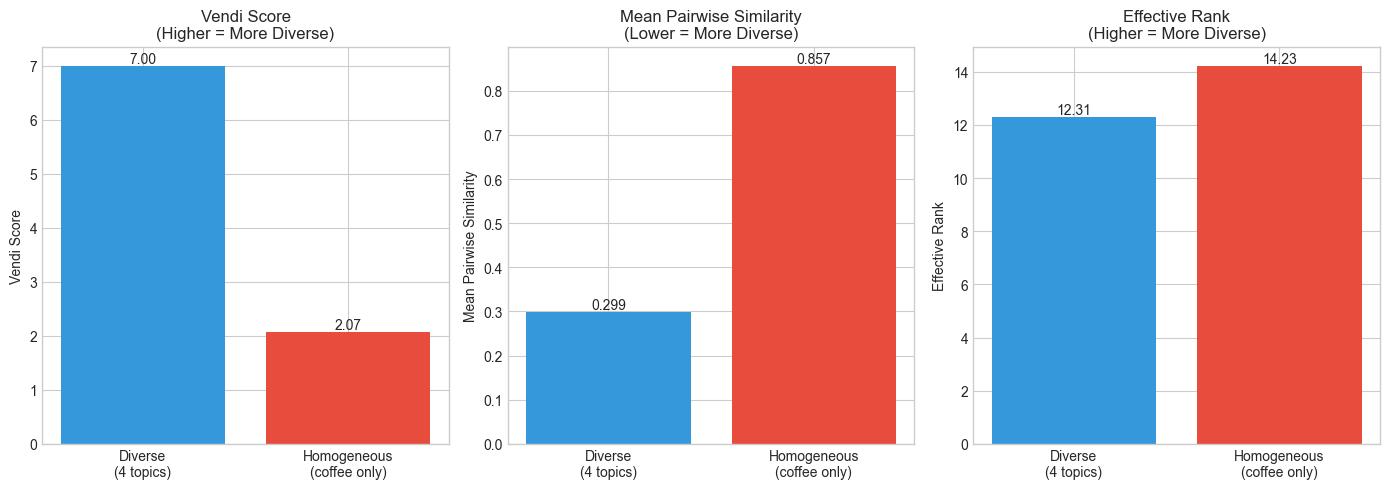

In [8]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Vendi Score
ax1 = axes[0]
bars1 = ax1.bar(['Diverse\n(4 topics)', 'Homogeneous\n(coffee only)'], 
               [report_a['vendi_score'], report_b['vendi_score']],
               color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Vendi Score')
ax1.set_title('Vendi Score\n(Higher = More Diverse)', fontsize=12)
ax1.bar_label(bars1, fmt='%.2f')

# Mean Pairwise Similarity
ax2 = axes[1]
bars2 = ax2.bar(['Diverse\n(4 topics)', 'Homogeneous\n(coffee only)'], 
               [report_a['mean_pairwise_similarity'], report_b['mean_pairwise_similarity']],
               color=['#3498db', '#e74c3c'])
ax2.set_ylabel('Mean Pairwise Similarity')
ax2.set_title('Mean Pairwise Similarity\n(Lower = More Diverse)', fontsize=12)
ax2.bar_label(bars2, fmt='%.3f')

# Effective Rank
ax3 = axes[2]
bars3 = ax3.bar(['Diverse\n(4 topics)', 'Homogeneous\n(coffee only)'], 
               [report_a['effective_rank'], report_b['effective_rank']],
               color=['#3498db', '#e74c3c'])
ax3.set_ylabel('Effective Rank')
ax3.set_title('Effective Rank\n(Higher = More Diverse)', fontsize=12)
ax3.bar_label(bars3, fmt='%.2f')

plt.tight_layout()
plt.show()

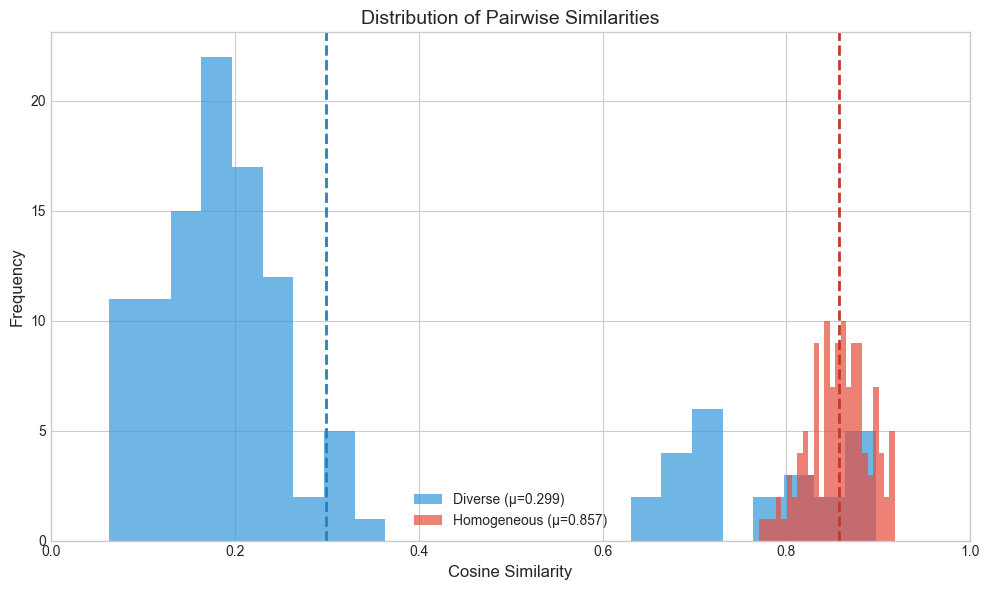

In [9]:
# Similarity distribution comparison
sim_matrix_a = pairwise_similarities(embeddings_a, metric="cosine")
sim_matrix_b = pairwise_similarities(embeddings_b, metric="cosine")

# Extract upper triangles (excluding diagonal)
n_a = len(embeddings_a)
n_b = len(embeddings_b)
sims_a = sim_matrix_a[np.triu_indices(n_a, k=1)]
sims_b = sim_matrix_b[np.triu_indices(n_b, k=1)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(sims_a, bins=25, alpha=0.7, label=f'Diverse (μ={np.mean(sims_a):.3f})', color='#3498db')
ax.hist(sims_b, bins=25, alpha=0.7, label=f'Homogeneous (μ={np.mean(sims_b):.3f})', color='#e74c3c')

ax.axvline(np.mean(sims_a), color='#2980b9', linestyle='--', linewidth=2)
ax.axvline(np.mean(sims_b), color='#c0392b', linestyle='--', linewidth=2)

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Pairwise Similarities', fontsize=14)
ax.legend()
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

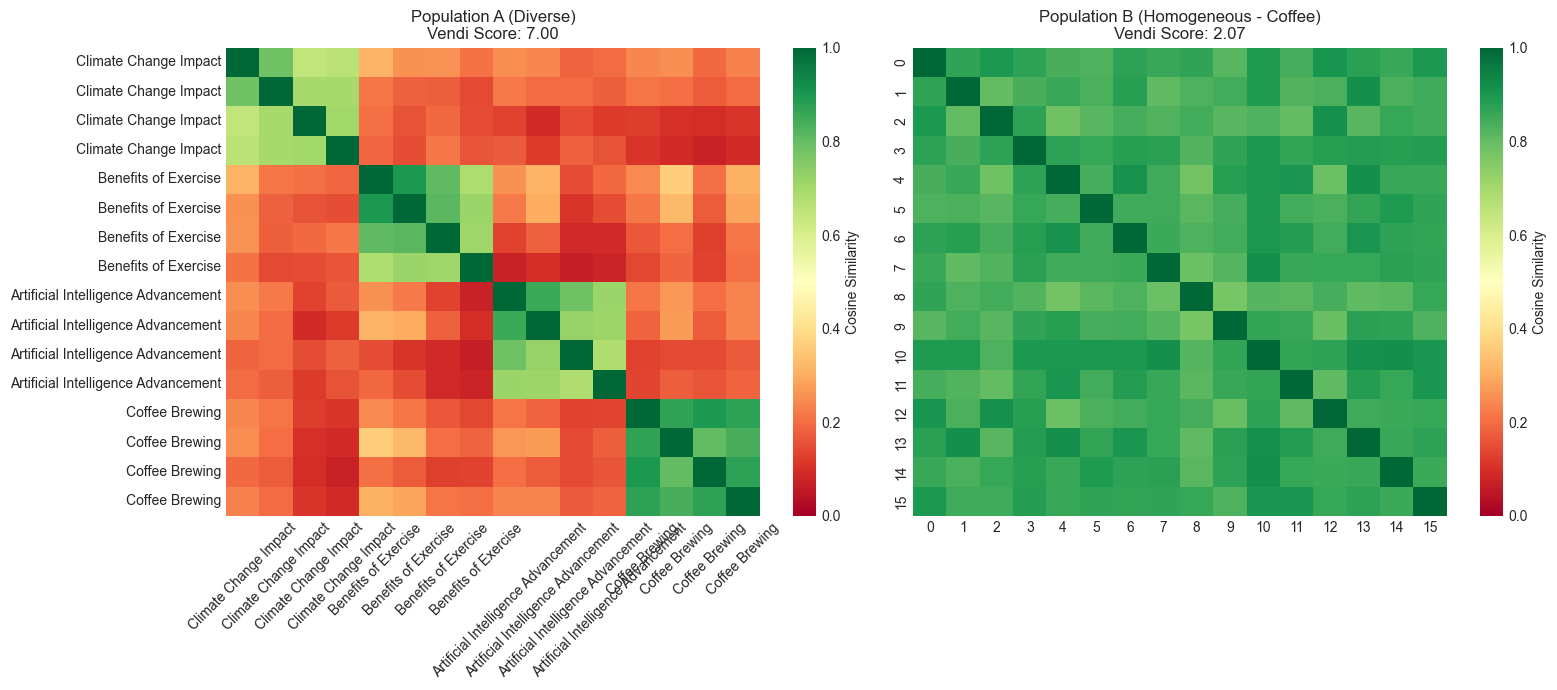

In [10]:
# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Population A heatmap
sns.heatmap(sim_matrix_a, ax=axes[0], cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=population_a_labels, yticklabels=population_a_labels,
            cbar_kws={'label': 'Cosine Similarity'})
axes[0].set_title(f'Population A (Diverse)\nVendi Score: {report_a["vendi_score"]:.2f}', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Population B heatmap
sns.heatmap(sim_matrix_b, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=1,
            cbar_kws={'label': 'Cosine Similarity'})
axes[1].set_title(f'Population B (Homogeneous - Coffee)\nVendi Score: {report_b["vendi_score"]:.2f}', fontsize=12)

plt.tight_layout()
plt.show()

## Conclusions

The diversity metrics successfully differentiate between the two populations:

1. **Vendi Score**: The diverse population has a significantly higher score, indicating more "effective unique items"
2. **Mean Pairwise Similarity**: The homogeneous population has much higher similarity between items
3. **Effective Rank**: The diverse population uses more dimensions of the embedding space

These metrics can be used to:
- Evaluate dataset diversity for training
- Assess retrieval result quality
- Compare different embedding models on the same corpus
- Set thresholds for semantic deduplication